# 🏠 Nashville Housing Data Cleaning
This notebook cleans and preprocesses the Nashville housing dataset.

In [31]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer


# Load dataset
df = pd.read_csv("Nashville_housing_data_2013_2016.csv")


In [32]:
# --- Standardize column names ---
df.columns = (df.columns
              .str.strip()
              .str.lower()
              .str.replace(' ', '_')
              .str.replace(r'[^\w_]', '', regex=True))

# --- Drop columns with >95% missing values ---
high_missing = df.columns[df.isnull().mean() > 0.95]
df.drop(columns=high_missing, inplace=True)

# --- Drop constant columns ---
nunique = df.nunique()
constant_cols = nunique[nunique == 1].index.tolist()
df.drop(columns=constant_cols, inplace=True)

# --- Drop ID-like "Unnamed" columns ---
unique_cols = [col for col in df.columns if col.lower().startswith("unnamed")]
df.drop(columns=unique_cols, inplace=True)

# --- Drop one of each highly correlated pair ---
drop_due_to_correlation = [
    'home_age', 'price_range', 'total_value',
    'land_use', 'owner_city', 'owner_state'
]
df.drop(columns=[col for col in drop_due_to_correlation if col in df.columns], inplace=True)

# --- Drop rows missing critical fields ---
required_columns = ['sale_price', 'year_built', 'property_address']
df.dropna(subset=[col for col in required_columns if col in df.columns], inplace=True)

# --- Fill missing values for remaining columns ---
for col in df.columns:
    if df[col].dtype in [np.float64, np.int64]:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna('Unknown')

# --- Fix imbalances ---

# 1. Group rare 'property_city' into "Other"
if 'property_city' in df.columns:
    city_counts = df['property_city'].value_counts(normalize=True)
    rare_cities = city_counts[city_counts < 0.05].index
    df['property_city'] = df['property_city'].replace(rare_cities, 'Other')

# 2. Normalize 'sold_as_vacant' values
if 'sold_as_vacant' in df.columns:
    df['sold_as_vacant'] = df['sold_as_vacant'].astype(str).str.strip().str.lower().replace({
        'y': 'Yes', 'yes': 'Yes', 'n': 'No', 'no': 'No'
    })

# 3. Convert 'multiple_parcels_involved_in_sale' to binary (0/1)
if 'multiple_parcels_involved_in_sale' in df.columns:
    df['multiple_parcels_involved_in_sale'] = df['multiple_parcels_involved_in_sale'].map({'Yes': 1, 'No': 0})

# 4. Group rare 'tax_district' values
if 'tax_district' in df.columns:
    tax_counts = df['tax_district'].value_counts(normalize=True)
    rare_tax = tax_counts[tax_counts < 0.05].index
    df['tax_district'] = df['tax_district'].replace(rare_tax, 'Other')

# 5. Group rare 'exterior_wall' values
if 'exterior_wall' in df.columns:
    wall_counts = df['exterior_wall'].value_counts(normalize=True)
    rare_walls = wall_counts[wall_counts < 0.05].index
    df['exterior_wall'] = df['exterior_wall'].replace(rare_walls, 'Other')

# 6. Group rare 'grade' values
if 'grade' in df.columns:
    grade_counts = df['grade'].value_counts(normalize=True)
    rare_grades = grade_counts[grade_counts < 0.05].index
    df['grade'] = df['grade'].replace(rare_grades, 'Other')

# 7. Bin 'half_bath' values greater than 2
if 'half_bath' in df.columns:
    df['half_bath'] = df['half_bath'].fillna(0)
    df['half_bath'] = df['half_bath'].clip(upper=2)

# 8. Transform skewed 'acreage'
if 'acreage' in df.columns:
    df['acreage_log'] = np.log1p(df['acreage'])
    pt = PowerTransformer(method='yeo-johnson')
    df['acreage_boxcox'] = pt.fit_transform(df[['acreage']])

# --- Final cleanup ---
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

# --- Save model-ready cleaned file ---
df.to_csv("nashville_model_ready_balanced.csv", index=False)
print("✅ All cleaning, transformation, and imbalance fixes complete. Saved as 'nashville_model_ready_balanced.csv'")

✅ All cleaning, transformation, and imbalance fixes complete. Saved as 'nashville_model_ready_balanced.csv'


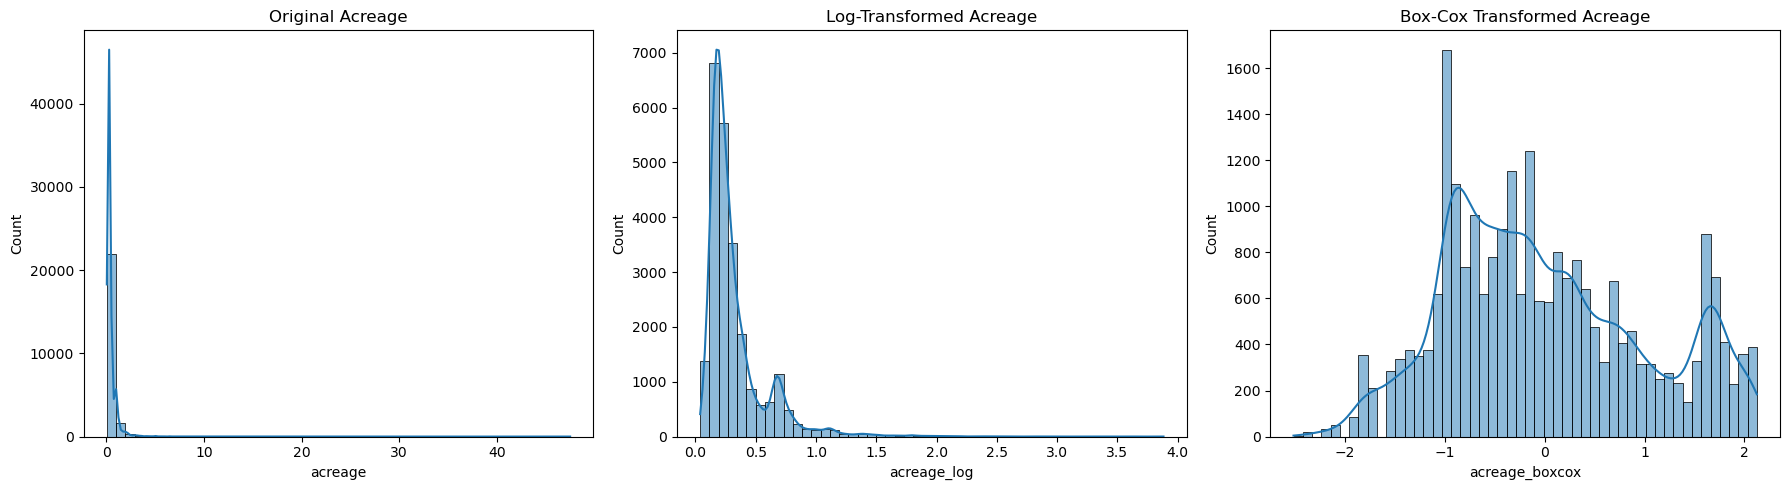

In [33]:
# Visualize original vs transformed
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df['acreage'], bins=50, ax=ax[0], kde=True).set(title='Original Acreage')
sns.histplot(df['acreage_log'], bins=50, ax=ax[1], kde=True).set(title='Log-Transformed Acreage')
sns.histplot(df['acreage_boxcox'], bins=50, ax=ax[2], kde=True).set(title='Box-Cox Transformed Acreage')

plt.tight_layout()
plt.show()

In [34]:
# Check for outliers in sale_price using the IQR method
Q1 = df['sale_price'].quantile(0.25)
Q3 = df['sale_price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['sale_price'] < lower_bound) | (df['sale_price'] > upper_bound)]
print(f"Number of outliers in sale_price: {len(outliers)}")
print("Top 5 outliers:")
display(outliers.sort_values('sale_price', ascending=False).head())

Number of outliers in sale_price: 1707
Top 5 outliers:


,parcel_id,property_address,suite_condo___,property_city,sale_date,sale_price,legal_reference,sold_as_vacant,multiple_parcels_involved_in_sale,owner_name,...,finished_area,foundation_type,year_built,exterior_wall,grade,bedrooms,full_bath,half_bath,acreage_log,acreage_boxcox
9060,073 00 0 042.00,2800 MCGAVOCK PIKE,Unknown,NASHVILLE,2014-08-15,12350000,20140818-0074498,No,1,CATHOLIC DIOCESE OF NASHVILLE,...,197988.00000,TYPICAL,1980.0,BRICK,Other,3.0,0.0,0.0,3.573469,2.123918
1927,117 07 0 137.00,3428 STOKESMONT RD,Unknown,NASHVILLE,2013-06-28,10750000,20130701-0067385,No,0,"HEAD, WILLIAM MICHAEL & BARR, STEPHENIE JANESE",...,4381.79999,PT BSMT,1953.0,BRICK,Other,4.0,3.0,1.0,0.378436,0.718303
508,130 03 0 122.00,540 JACKSON BLVD,Unknown,NASHVILLE,2013-03-01,7200000,20130301-0020968,No,0,"CHAPMAN, WILLIAM T. IV, TRUSTEE",...,10519.29993,PT BSMT,1990.0,Other,Other,5.0,8.0,0.0,2.183802,2.121485
12173,144 00 0 102.00,34 BANCROFT PL,Unknown,NASHVILLE,2015-03-09,5000000,20150310-0020538,No,1,"30 BANCROFT PLACE TRUST, THE",...,11221.00000,PT BSMT,2005.0,Other,Other,5.0,4.0,2.0,1.249902,2.058414
23098,144 01 0 005.00,1303 CHICKERING RD,Unknown,NASHVILLE,2016-09-02,5000000,20160907-0094170,No,0,"1303 CHICKERING TRUST, THE",...,5167.00000,PT BSMT,1929.0,BRICK,Other,6.0,4.0,0.0,1.768150,2.113355


In [35]:
# Remove outliers in sale_price using the IQR method
df = df[(df['sale_price'] >= lower_bound) & (df['sale_price'] <= upper_bound)]
print(f"✅ Outliers removed. Remaining rows: {len(df)}")

✅ Outliers removed. Remaining rows: 22411


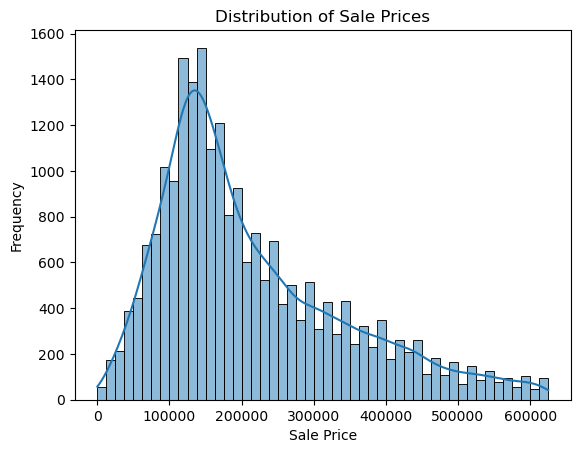

In [36]:
# Histogram of sale prices
sns.histplot(df['sale_price'], bins=50, kde=True)
plt.title("Distribution of Sale Prices")
plt.xlabel("Sale Price")
plt.ylabel("Frequency")
plt.show()


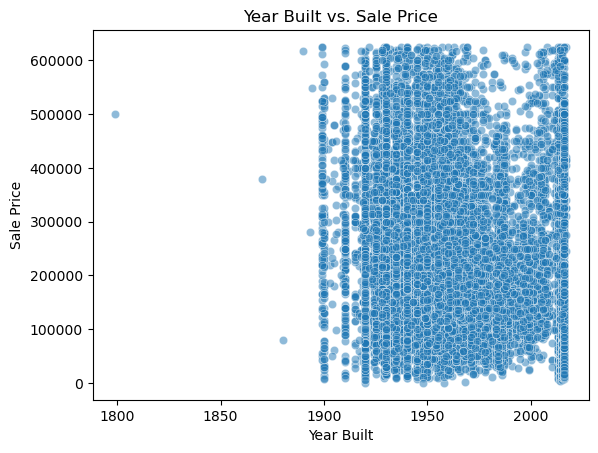

In [37]:
# Scatter plot: Year built vs Sale Price
sns.scatterplot(data=df, x='year_built', y='sale_price', alpha=0.5)
plt.title("Year Built vs. Sale Price")
plt.xlabel("Year Built")
plt.ylabel("Sale Price")
plt.show()


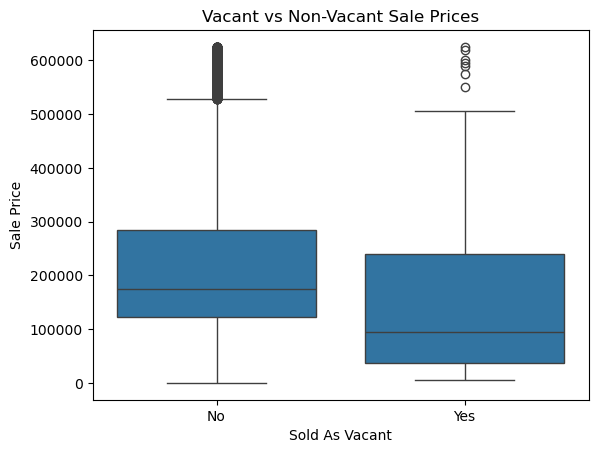

In [38]:
# Boxplot: Vacant vs Non-Vacant Sales
if 'sold_as_vacant' in df.columns:
    sns.boxplot(data=df, x='sold_as_vacant', y='sale_price')
    plt.title("Vacant vs Non-Vacant Sale Prices")
    plt.xlabel("Sold As Vacant")
    plt.ylabel("Sale Price")
    plt.show()


In [39]:
# Remove rows with missing values only in year_built
df = df.dropna(subset=['year_built'])
print(f"✅ Rows with missing year_built removed. Remaining rows: {len(df)}")

✅ Rows with missing year_built removed. Remaining rows: 22411


In [40]:
# Home age feature
if 'year_built' in df.columns:
    df['home_age'] = 2025 - df['year_built']

# Categorize price range
df['price_range'] = pd.cut(
    df['sale_price'],
    bins=[0, 100000, 250000, 500000, 1000000],
    labels=["Low", "Mid", "High", "Luxury"]
)

df[['sale_price', 'price_range', 'home_age']].head()


,sale_price,price_range,home_age
0,191500,Mid,84.0
1,202000,Mid,25.0
2,32000,Low,77.0
3,102000,Mid,115.0
4,93736,Low,80.0


In [41]:
# Create an interactive profiling report
try:
    from ydata_profiling import ProfileReport
    profile = ProfileReport(df, title="Nashville Housing Report", explorative=True)
    profile.to_file("nashville_housing_report.html")
    print("✅ Profile report generated.")
except ImportError:
    print("⚠️ ydata_profiling not installed. Run: pip install ydata-profiling")


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 21.75it/s]

✅ Profile report generated.
